In [1]:
import Colors
import Statistics
import FileIO

In [2]:
include("../ToolBox/ToolBox.jl")
using .ToolBox
using .Geometry

proj_create: init=epsg:/init=IGNF: syntax not supported in non-PROJ4 emulation mode


In [3]:
simon = "/Users/simon/Data/Sentinel/"
eigil = "/Users/eyu/YOEO_local/data/"
pre_path = eigil

master_data_path = pre_path * "S1B_IW_SLC__1SDV_20170315T053950_20170315T054018_004715_0083B0_7EE9.SAFE/measurement/s1b-iw3-slc-vv-20170315t053950-20170315t054018-004715-0083b0-006.tiff"
master_meta_path = pre_path * "S1B_IW_SLC__1SDV_20170315T053950_20170315T054018_004715_0083B0_7EE9.SAFE/annotation/s1b-iw3-slc-vv-20170315t053950-20170315t054018-004715-0083b0-006.xml"
master_pod_path  = pre_path * "S1B_OPER_AUX_POEORB_OPOD_20170404T111500_V20170314T225942_20170316T005942.EOF"

slave_data_path = pre_path * "S1B_IW_SLC__1SDV_20170327T053950_20170327T054018_004890_0088AE_3CC1.SAFE/measurement/s1b-iw3-slc-vv-20170327t053950-20170327t054018-004890-0088ae-006.tiff"
slave_meta_path = pre_path * "S1B_IW_SLC__1SDV_20170327T053950_20170327T054018_004890_0088AE_3CC1.SAFE/annotation/s1b-iw3-slc-vv-20170327t053950-20170327t054018-004890-0088ae-006.xml"
slave_pod_path = pre_path * "S1B_OPER_AUX_POEORB_OPOD_20170416T111343_V20170326T225942_20170328T005942.EOF"

#dem_path = "/Users/simon/Data/DEM/srtm_38_01/srtm_38_01_transformed.tif"
dem_path = "/Users/eyu/YOEO_local/data/srtm_38_01/srtm_38_01_reprojected.tif"

"/Users/eyu/YOEO_local/data/srtm_38_01/srtm_38_01_reprojected.tif"

proj_create: init=epsg:/init=IGNF: syntax not supported in non-PROJ4 emulation mode


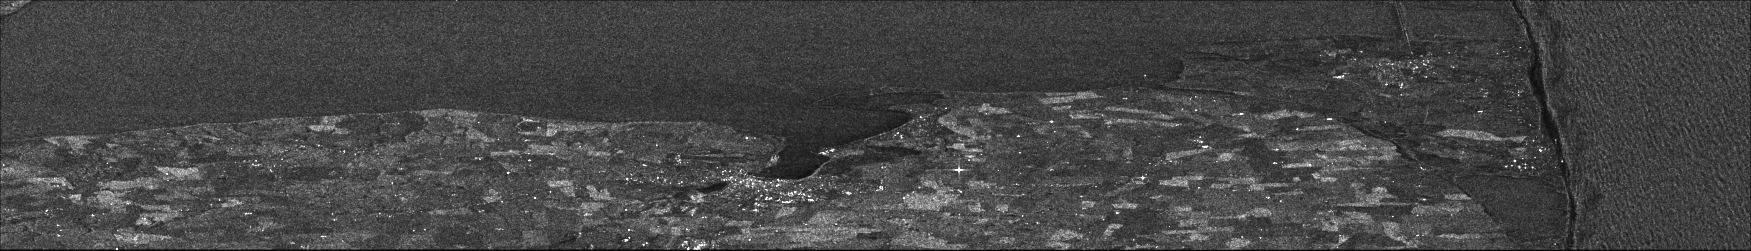

In [4]:
master_view = [500:1500,3000:10000]
master_data = Load.slc_data(master_data_path,master_view)
SlcUtil.show_img(master_data,0.995)

In [5]:
# load meta and pod
master_meta = Load.slc_meta(master_meta_path);
master_precise_orbit = Load.precise_orbit(master_pod_path,master_meta["t_0"]);
slave_meta = Load.slc_meta(slave_meta_path);
slave_precise_orbit = Load.precise_orbit(slave_pod_path,slave_meta["t_0"]);

meta = (master_meta,slave_meta)
precise_orbit = (master_precise_orbit,slave_precise_orbit);

In [6]:
# load DEM
footprint = SlcUtil.footprint(master_meta, master_view)
latlon_window = ((minimum(footprint[1]),maximum(footprint[1])),(minimum(footprint[2]),maximum(footprint[2])))
dem = Load.dem(dem_path, latlon_window; nan_fill= 0, padding=[90,90]);

proj_create: init=epsg:/init=IGNF: syntax not supported in non-PROJ4 emulation mode


In [7]:
lut = look_up_table(master_view,meta,precise_orbit,dem,stride=(2,8));

## Resample

In [8]:
dim = (length(master_view[1]),length(master_view[2]))

(1001, 7001)

### load slave image data

In [30]:
padd = 2

slave_view = round(Int,minimum(lut["slave_line"])-padd): round(Int,maximum(lut["slave_line"])+padd),
            round(Int,minimum(lut["slave_sample"])-padd): round(Int,maximum(lut["slave_sample"])+padd)
slave_data = Load.slc_data(slave_data_path, slave_view);

proj_create: init=epsg:/init=IGNF: syntax not supported in non-PROJ4 emulation mode


In [31]:
using PyCall
ndimage = pyimport("scipy.ndimage");

In [32]:
inds = [lut["slave_line"].-slave_view[1].start, lut["slave_sample"].-slave_view[2].start]
slave_re = ndimage.map_coordinates(real.(slave_data), inds, order=1, mode="nearest")
slave_im = ndimage.map_coordinates(imag.(slave_data), inds, order=1, mode="nearest")
inds = 0
slave_resample = slave_re .+ slave_im.*im
slave_re = 0
slave_im = 0

slave_resample = reshape(slave_resample, dim);

In [33]:
function plot_phase(img)
    phase = (angle.(img) .+pi)./(2*pi)
    return Colors.RGB{Float32}.(1 .-phase.^2,4 .*(phase .-  phase.^2),phase.^2)
end

plot_phase (generic function with 1 method)

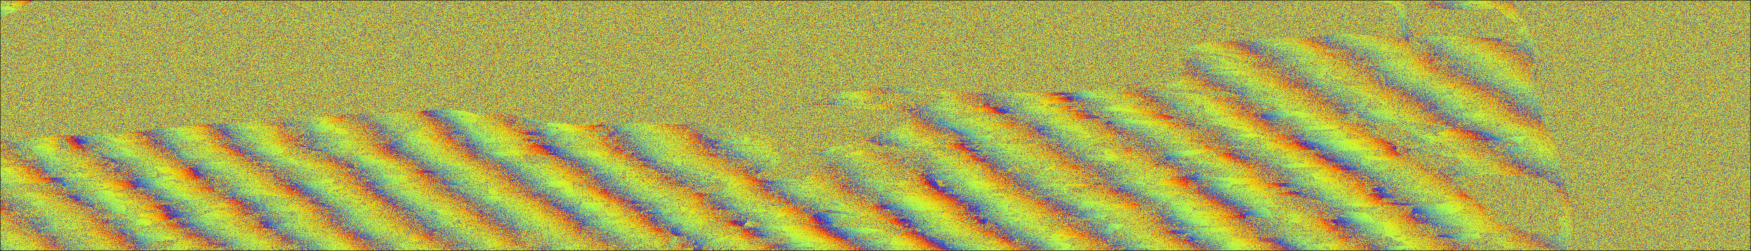

In [34]:
infero = master_data .* conj.(slave_resample)
plot_phase(infero)

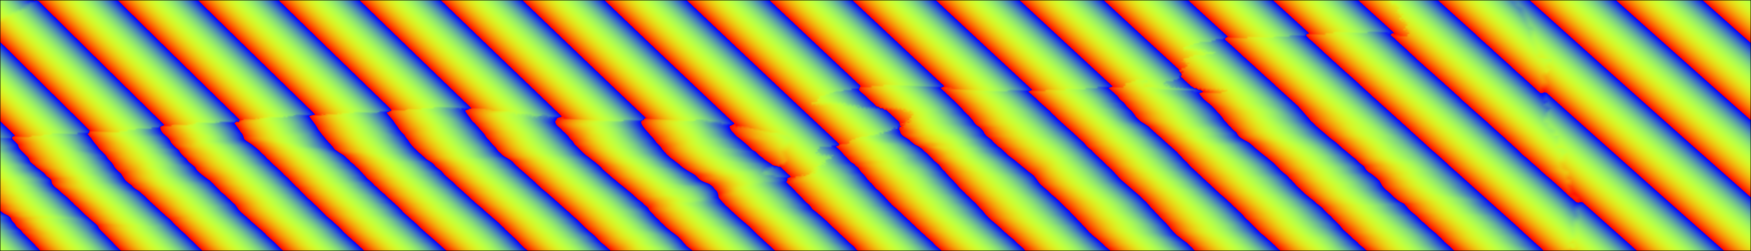

In [39]:
c = 299792458
range_pixel_spacing =  c/(2*meta[1]["range_sampling_rate"])
lambda =  c/meta[1]["radar_frequency"]
flat = exp.(4*pi.*(lut["master_sample"].-lut["slave_sample"]).*range_pixel_spacing./lambda.*im)
flat = reshape(flat,dim);
plot_phase(flat)

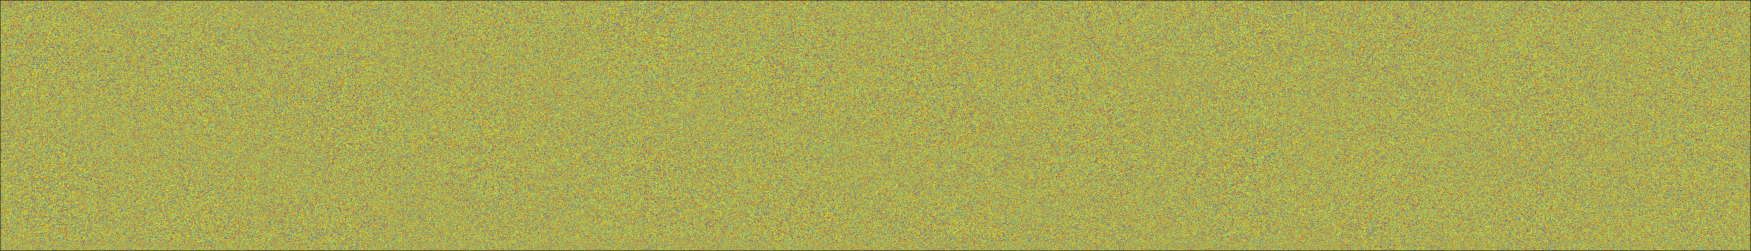

In [40]:
plot_phase(infero.*flat)

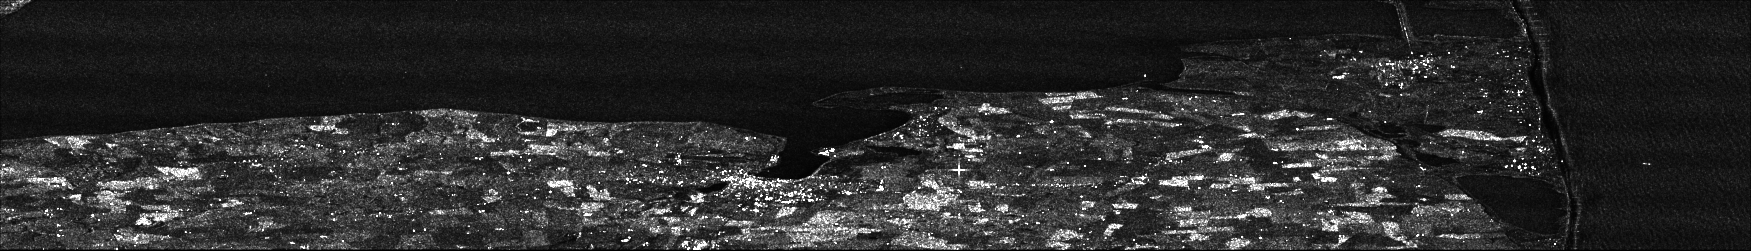

In [32]:
SlcUtil.show_img(infero,0.98)

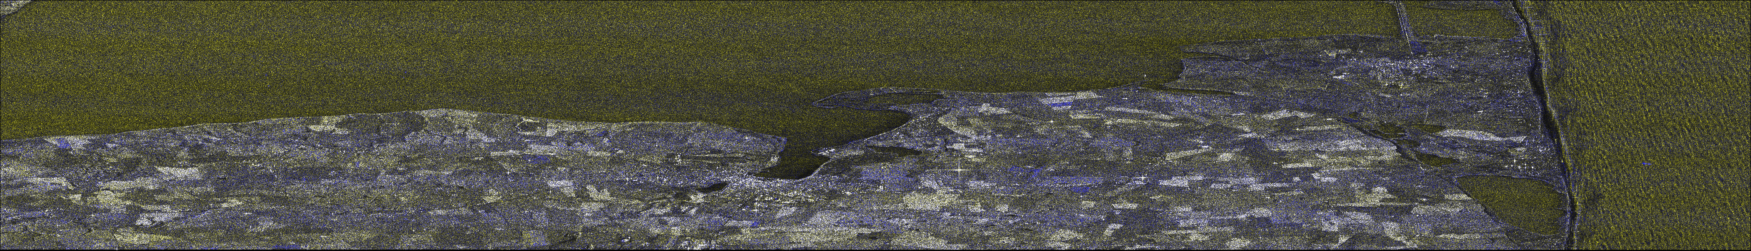

In [13]:
max_quantile = 0.99
temp_master = abs.(master_data)./Statistics.quantile(reshape(abs.(master_data), :), max_quantile)
temp_slave = abs.(slave_resample)./Statistics.quantile(reshape(abs.(slave_resample), :), max_quantile);
temp_master[temp_master .> 1] .= 1
temp_slave[temp_slave .> 1] .= 1

color_img = Colors.RGB{Float32}.(temp_master,temp_master,temp_slave)

In [14]:
FileIO.save("infero_no_flat.jpg",plot_phase(infero.*flat))
FileIO.save("color_img.jpg", color_img)
FileIO.save("infero.jpg", infero)

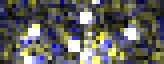

In [15]:
show_lines = 1120-master_view[1].start : 1135-master_view[1].start
show_samples = 6080-master_view[2].start : 6120-master_view[2].start
color_img[show_lines,show_samples]

In [16]:
FileIO.save("resample.jpg", color_img[show_lines,show_samples])